In [1]:
# https://arxiv.org/pdf/2412.06264
%matplotlib inline
from tinygrad import Tensor, nn, TinyJit
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Flow:
  def __init__(self, dim=2, h=64):
    self.net = [
      nn.Linear(dim+1, h), Tensor.elu,
      nn.Linear(h, h), Tensor.elu,
      nn.Linear(h, h), Tensor.elu,
      nn.Linear(h, dim)]

  def __call__(self, x_t:Tensor, t:Tensor) -> Tensor:
    return t.cat(x_t, dim=-1).sequential(self.net)

  def step(self, x_t:Tensor, t_start:Tensor, t_end:Tensor) -> Tensor:
    t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
    # For simplicity, using midpoint ODE solver in this example
    return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2, t_start + (t_end - t_start) / 2)

In [3]:
flow = Flow()
optimizer = nn.optim.Adam(nn.state.get_parameters(flow), 1e-2)

In [4]:
@TinyJit
@Tensor.train()
def train(x_1:Tensor):
  x_0 = Tensor.randn_like(x_1)
  t = Tensor.rand(len(x_1), 1)
  x_t = (1 - t) * x_0 + t * x_1
  dx_t = x_1 - x_0
  optimizer.zero_grad()
  (flow(x_t, t) - dx_t).square().mean().backward()
  optimizer.step()

for _ in range(10000):
  x_1 = Tensor(make_moons(256, noise=0.05)[0].astype(np.float32))
  train(x_1)

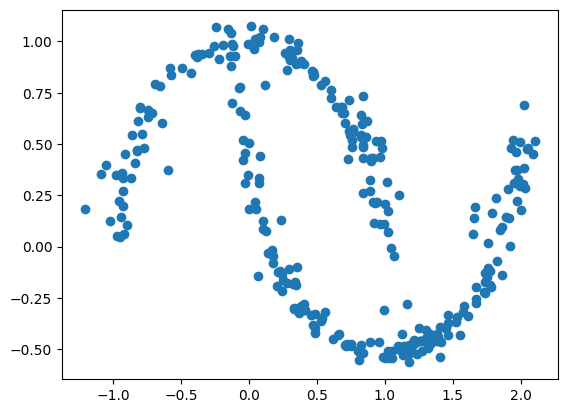

In [5]:
x = Tensor.randn(300, 2)
n_steps = 8
time_steps = Tensor.linspace(0, 1.0, n_steps + 1)
for i in range(n_steps):
  x = flow.step(x, time_steps[i], time_steps[i+1])
xn = x.numpy()
plt.scatter(xn[:, 0], xn[:, 1])